In [1]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("/home/shiva/Downloads/datasets/WK_1.csv",compression='gzip')
df.drop_duplicates('cleaned_data',inplace=True)

In [3]:
print(df.shape)
df.head()

(5373, 33)


,Unnamed: 0,cleaned_data,Administrative Law,Attorneys Fees,Banking Law,Bankruptcy Law,Civil Procedure,Civil Rights,Class Actions,Commercial Law,...,Immigration Law,Injury & Tort Law,Insurance Law,Intellectual Property,Labor & Employment Law,Property Law & Real Estate,Remedies,Sanctions,Securities Law,Sentencing
0,0,immaterial exception pendency motion suit dist...,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,consideration motion opinion case slip opinion...,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,3,terms time dismissal labor organization IAWCs ...,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,Plaintiffs limited ambulatory surgical center ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,possession firearm jury trial jury court mistr...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


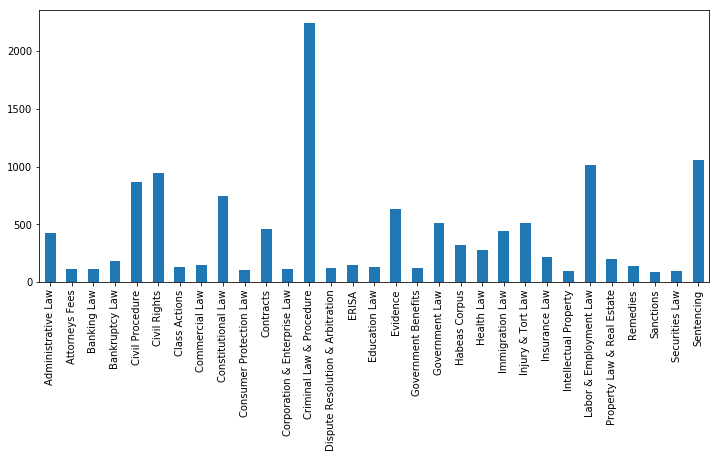

In [4]:
categories=df.columns
cat=[df[c].value_counts() for c in categories[2:]]
plt.figure(figsize=(12,5))
df.iloc[:,2:].sum(axis=0).plot.bar()

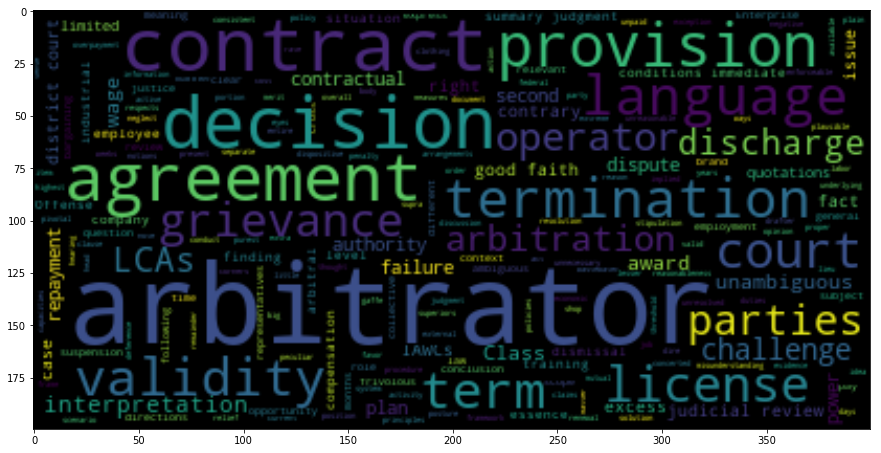

In [5]:
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud().generate(df.iloc[2]['cleaned_data'])
plt.imshow(wordcloud, interpolation="bilinear")

In [6]:
# df['word_len']=df.cleaned_data.apply(lambda x:len(simple_preprocess(x)))
# df_=df.loc[df.word_len>=50]
# df_.head(2)

In [7]:
labels = df[list(df.head(0))[2:]]
labels.drop(columns=['Criminal Law & Procedure'],inplace=True)

/home/shiva/python_projects_directory/python_projects_env/lib/python3.5/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
X_split =df["cleaned_data"].apply(func=preprocess_text)
y_split = labels
y_split.shape

(5373, 30)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.20, random_state=420)
# First output
yt_train = [y_train[c] for c in list(y_train.head(0))]
yt_test =  [y_test[c] for c in list(y_test.head(0))]
X_train.shape,np.array(y_train).shape

((4298,), (4298, 30))

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_ = tokenizer.texts_to_sequences(X_train)
X_test_ = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_pad = pad_sequences(X_train_, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_, padding='post', maxlen=maxlen)
X_train_pad.shape

(4298, 200)

In [12]:
# required float sequenced values
som = MiniSom(x= 1, y =31 , input_len = 200, sigma=0.1, learning_rate=0.2)
som.random_weights_init(X_train_pad)
starting_weights = som.get_weights().copy()
som.train_random(X_train_pad, 100)
qnt = som.quantization(X_train_pad)

In [13]:
# clustered = np.zeros(X_train.shape)

In [14]:
# from sklearn.metrics.pairwise import linear_kernel
# cosine_similarities = linear_kernel(X_train[0:1], X_train).flatten()
# # 10 most related documents indices
# related_docs_indices = cosine_similarities.argsort()[:-11:-1]
# print("Related Document:",related_docs_indices)

# # Cosine Similarties of related documents
# print("Cosine Similarites of related documents",cosine_similarities[related_docs_indices])

In [15]:
import gensim
from gensim.models import Doc2Vec

def doc2vec(X_train):
    document_tagged = []
    tagged_count = 0
    for line in X_train:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(line,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs

In [16]:
from sklearn.decomposition import PCA
def pca_fun(n_components, data):
    pca = PCA(n_components=n_components).fit(data)
    data = pca.transform(data)
    return data

In [17]:
# Let's explore the data representation of doc2vec for abstract column.
# Visualization the doc2vec representation
doc2vec = doc2vec(X_train) # takes string values

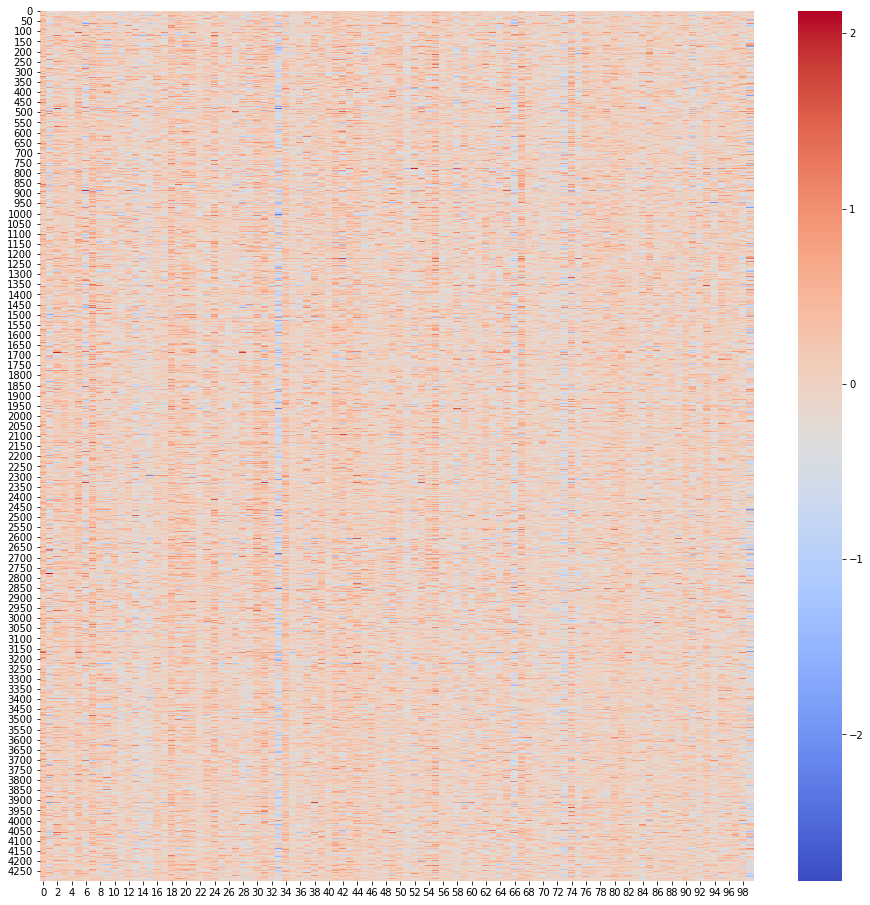

In [18]:
import seaborn as sns
plt.figure(figsize=(16,16))
sns.heatmap(doc2vec,cmap="coolwarm")

In [19]:
import somoclu
def som(data):
    som = somoclu.Somoclu(50,31, data=data, maptype="toroid")
    %time som = som.train(data)
    print("Comonent Planes")
    return som

In [20]:
pca_data = pca_fun(2,doc2vec)
som = som(pca_data)

CPU times: user 6.69 s, sys: 61.2 ms, total: 6.75 s
Wall time: 1.72 s
Comonent Planes


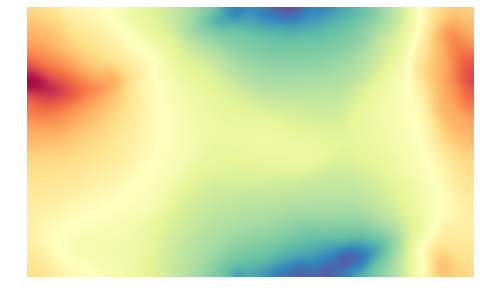

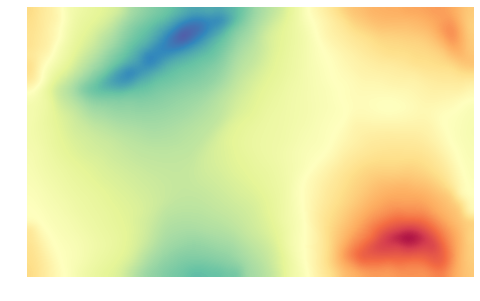

<module 'matplotlib.pyplot' from '/home/shiva/python_projects_directory/python_projects_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [21]:
#Exploring Component Planes
#labels is 0 to n(document-0, document-1,...documentn) 
labels = range(0,pca_data.shape[0])

# Step4: Exploring Content Planes
som.view_component_planes() 

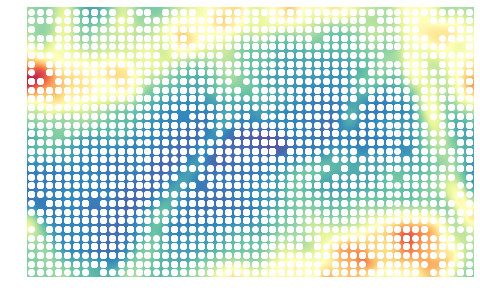

<module 'matplotlib.pyplot' from '/home/shiva/python_projects_directory/python_projects_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [22]:
# Step 5: Exploring clusters by SOM reinforced with  Doc2Vec
som.view_umatrix(bestmatches = True)

In [23]:
# importing KMeans library of sklearn
from sklearn.cluster import KMeans
def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

In [24]:
kmeans5 = KMeans(31)
%time km5 = kmeans5.fit_predict(pca_data)
meta_data = kmeans5.labels_

CPU times: user 593 ms, sys: 0 ns, total: 593 ms
Wall time: 700 ms


In [25]:
color_code=['#ff0000','#cc0000','#660033','#cc3300','#cc0066','#cc0066','#ff6600','#ffcc00','#cccc00','#999966',
       '#666633','#990099','#ccff33','#66ff33','#ffffcc','#ff99cc','#cc00ff','#99ccff','#66ffff','#333300',
      '#333300','#cc99ff','#00cc99','#cc6699','#0000ff','#3333cc','#666699','#000099','#333399','#336699','#006666']
color = [color_code[i] for i in list(meta_data)]

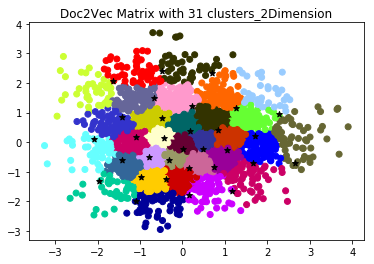

In [44]:
centroids =  pca_fun(2,kmeans5.cluster_centers_)
plt.scatter(pca_data[:, 0], pca_data[:, 1],c = color)
plt.scatter(centroids[:, 0], centroids[:, 1],marker='*',c='#000000',norm='l1')
plt.title("Doc2Vec Matrix with 31 clusters_2Dimension")
plt.show()

In [36]:
dataframe =pd.DataFrame()
dataframe['cluster'] = meta_data
dataframe['x'] =pca_data[:, 0]
dataframe['y'] =pca_data[:, 1]

In [37]:
dataframe.dropna(inplace=True)

In [38]:
dataframe.head()

,cluster,x,y
0,23,0.527463,-0.443510
1,9,-0.253580,-0.337767
2,15,-0.108131,1.010067
3,0,-0.992458,2.010907
4,28,0.338364,-0.146810


In [39]:
freq={i:meta_data.tolist().count(i) for i in range(31)}
freq

{0: 57,
 1: 161,
 2: 372,
 3: 171,
 4: 169,
 5: 80,
 6: 94,
 7: 145,
 8: 158,
 9: 247,
 10: 59,
 11: 209,
 12: 41,
 13: 102,
 14: 220,
 15: 157,
 16: 95,
 17: 35,
 18: 53,
 19: 159,
 20: 46,
 21: 219,
 22: 44,
 23: 264,
 24: 116,
 25: 90,
 26: 111,
 27: 68,
 28: 215,
 29: 132,
 30: 209}

In [41]:
import gensim
from gensim.models import Doc2Vec

def doc2vec(X_train):
    document_tagged = []
    tagged_count = 0
    for line in X_train:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(line,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs

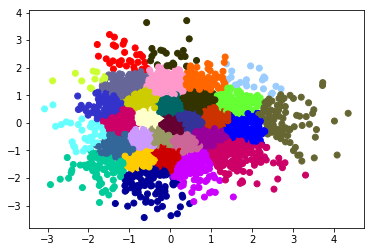

In [46]:
doc2vec_test = doc2vec(df.cleaned_data)
pca_data_test = pca_fun(2,doc2vec_test)
centroids =  pca.transform(kmeans5.cluster_centers_)
pred=kmeans5.predict(pca_data_test)
color_code=['#ff0000','#cc0000','#660033','#cc3300','#cc0066','#cc0066','#ff6600','#ffcc00','#cccc00','#999966',
       '#666633','#990099','#ccff33','#66ff33','#ffffcc','#ff99cc','#cc00ff','#99ccff','#66ffff','#333300',
      '#333300','#cc99ff','#00cc99','#cc6699','#0000ff','#3333cc','#666699','#000099','#333399','#336699','#006666']
color_test = [color_code[i] for i in list(pred)]
plt.scatter(pca_data_test[:, 0], pca_data_test[:, 1],c=color_test)
# plt.scatter(centroids[:, 0], centroids[:, 1])

In [52]:
kmeans5.predict([pca_data_test[56]]) 

array([8], dtype=int32)